## Import Libraries

In [3]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

## Read Data

In [5]:
data = load_breast_cancer()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target
df['target'] = df['target'].replace({0: 1, 1: 0})

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## Target Variable

In [7]:
# 357 benign, 212 malignant - roughly balanced data
df.target.value_counts()

target
0    357
1    212
Name: count, dtype: int64

In [8]:
# Split data into train and test sets (80% train, 20% test)
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, stratify=df['target'], random_state=10)


# Split data into features and target
X = X_train_main
y = y_train_main

## Nested Cross-Validation Setup

In [10]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

param_grids = {
    "Decision_Tree": {
        "clf__max_depth": [3, 5, 10, None],
        "clf__min_samples_split": [2, 5, 10]
    },
    "KNN": {
        "clf__n_neighbors": [3, 5, 7, 9],
        "clf__weights": ['uniform', 'distance']
    },
    "Logistic_Regression": {
        "clf__C": [0.001,0.01, 0.1, 1, 10, 100],
        "clf__penalty": ['l1', 'l2'],
        "clf__solver": ['liblinear']
    },
    "SVM": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ['linear', 'rbf', 'poly']
    }
}

models = {
    "Decision_Tree": DecisionTreeClassifier(random_state=10),
    "KNN": KNeighborsClassifier(),
    "Logistic_Regression": LogisticRegression(random_state=10),
    "SVM": SVC(probability=True, random_state=10)
}

scoring_metrics = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score)
}

## Run Nested Cross-Validation for Each Model

In [12]:
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    scores = {metric: [] for metric in scoring_metrics.keys()}
    
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)  
        X_test_scaled = scaler.transform(X_test)  

        pipeline = Pipeline([("clf", model)])

        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=inner_cv, scoring="recall", n_jobs=-1, refit=True)
        grid_search.fit(X_train_scaled, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_scaled)
        
        for metric, scorer in scoring_metrics.items():
            scores[metric].append(scorer._score_func(y_test, y_pred))

    results[model_name] = {
        "Accuracy": np.mean(scores["accuracy"]),
        "Precision": np.mean(scores["precision"]),
        "Recall": np.mean(scores["recall"]),
        "Recall Std": np.std(scores["recall"]),  
        "F1-Score": np.mean(scores["f1"]),
        "AUC": np.mean(scores["roc_auc"])
    }

results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

Training Decision_Tree...
Training KNN...
Training Logistic_Regression...
Training SVM...


,Accuracy,Precision,Recall,Recall Std,F1-Score,AUC
Decision_Tree,0.920879,0.895941,0.894118,0.044019,0.894267,0.915480
KNN,0.964835,0.976471,0.929412,0.029994,0.951849,0.957688
Logistic_Regression,0.975824,0.981985,0.952941,0.023529,0.967068,0.971207
SVM,0.969231,0.964864,0.952941,0.014409,0.958641,0.965944


## Final Logistic_Regression Model Run 
Hyperparameter Tuning, Training and Performance Metrics


Best Hyperparameters for Logistic Regression:
   clf__C clf__penalty clf__solver
0     1.0           l2   liblinear

Final Model Performance Metrics:
   Accuracy  Precision    Recall  F1-Score       AUC
0  0.973684    0.97561  0.952381  0.963855  0.969246


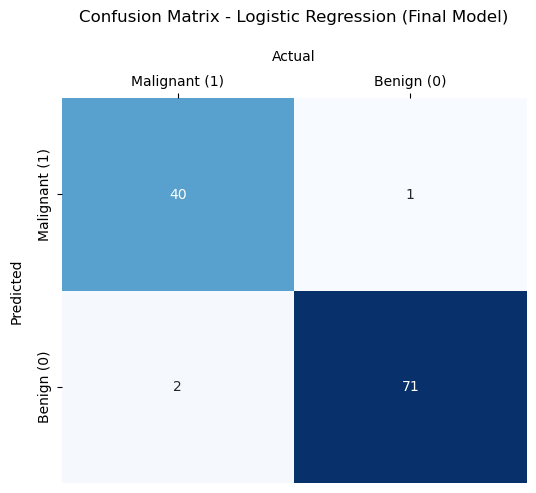

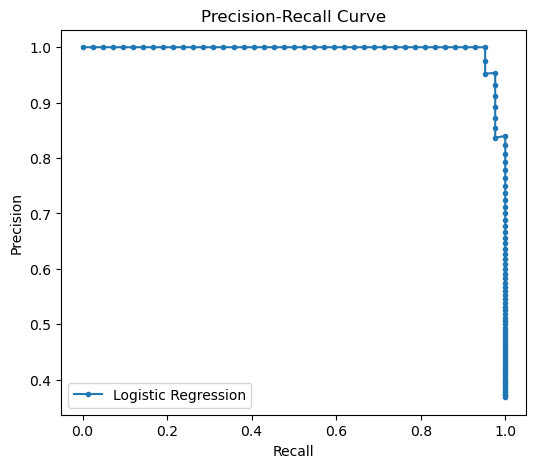

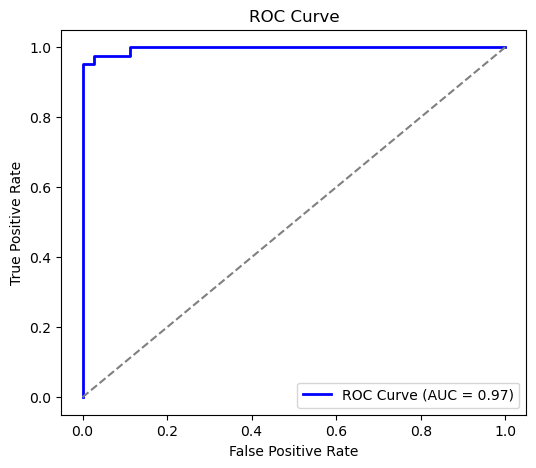

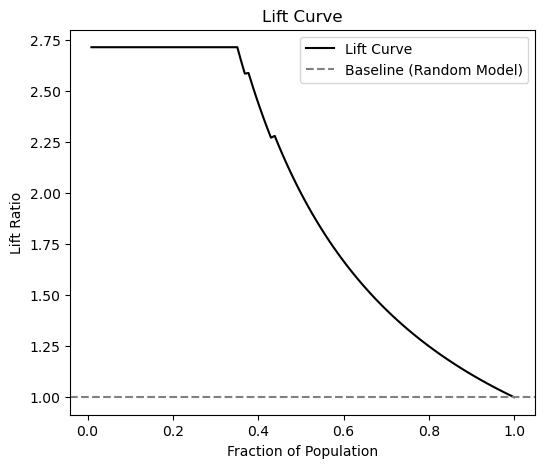

In [32]:
scoring_metric = 'recall'

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 20, 50, 70, 100],  
    'clf__penalty': ['l1', 'l2'],  
    'clf__solver': ['liblinear']  
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

best_params_list = []
nested_scores = []


for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pipeline = Pipeline([
        ("clf", LogisticRegression(random_state=1))
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring=scoring_metric, n_jobs=-1, refit=True)
    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    best_params_list.append(grid_search.best_params_)

    y_pred = best_model.predict(X_test_scaled)

    recall = recall_score(y_test, y_pred)
    nested_scores.append(recall)

best_params_final = pd.DataFrame(best_params_list).mode().iloc[0].to_dict()

final_model = LogisticRegression(C=best_params_final["clf__C"], penalty=best_params_final["clf__penalty"], solver='liblinear', random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_main)

final_model.fit(X_train_scaled, y)

y_pred_final = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

final_metrics = {
    "Accuracy": accuracy_score(y_test_main, y_pred_final),
    "Precision": precision_score(y_test_main, y_pred_final),
    "Recall": recall_score(y_test_main, y_pred_final),
    "F1-Score": f1_score(y_test_main, y_pred_final),
    "AUC": roc_auc_score(y_test_main, y_pred_final)
}

final_metrics_df = pd.DataFrame([final_metrics])
best_params_df = pd.DataFrame([best_params_final])

print("\nBest Hyperparameters for Logistic Regression:")
print(best_params_df)

print("\nFinal Model Performance Metrics:")
print(final_metrics_df)

conf_matrix = confusion_matrix(y_test_main, y_pred_final)

confusion_matrices = [conf_matrix]

# Confusion Matrix
selected_fold_cm = confusion_matrices[-1]
selected_fold_cm_plot = np.array([
    [selected_fold_cm[1, 1], selected_fold_cm[0, 1]],  
    [selected_fold_cm[1, 0], selected_fold_cm[0, 0]]   
])

plt.figure(figsize=(6, 5))
ax = sns.heatmap(selected_fold_cm_plot, annot=True, fmt='g', cmap='Blues', cbar=False, 
                 xticklabels=['Malignant (1)', 'Benign (0)'], 
                 yticklabels=['Malignant (1)', 'Benign (0)'])
ax.xaxis.set_ticks_position('top')  
ax.xaxis.set_label_position('top')
plt.title('Confusion Matrix - Logistic Regression (Final Model)', pad=20, loc='center')
plt.xlabel('Actual', labelpad=10)
plt.ylabel('Predicted', labelpad=10)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_main, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label="Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_main, y_pred_proba)
roc_auc = roc_auc_score(y_test_main, y_pred_final)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Lift Curve
lift_df = pd.DataFrame({"prob": y_pred_proba, "adopter_yes": (y_test_main == 1).astype(int)})

lift_df = lift_df.sort_values(by="prob", ascending=False).reset_index(drop=True)

lift_df["x"] = (lift_df.index + 1) / len(lift_df)

lift_df["y"] = (lift_df["adopter_yes"].cumsum() / lift_df["adopter_yes"].sum()) / lift_df["x"]

# Plot Lift Curve
plt.figure(figsize=(6, 5))
plt.plot(lift_df["x"], lift_df["y"], color='black', lw=1.5, label="Lift Curve")
plt.axhline(y=1, color='grey', linestyle="--", label="Baseline (Random Model)")
plt.xlabel("Fraction of Population")
plt.ylabel("Lift Ratio")
plt.title("Lift Curve")
plt.legend()
plt.show()